<a href="https://colab.research.google.com/github/Astro-Reza/VoronoiCells/blob/main/Voronoi_Cells_Resolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voronoi Cells Resolutions**

This script generates a Voronoi Tessellation to evaluate the sampling resolution of a spatial pointing pattern.

In this context:

- Seeds (Red Dots): Represent discrete pointing vectors (e.g., the direction a telescope, laser, or sensor is pointing).
- Voronoi Cells (Colored Polygons): Represent the effective resolution or "catchment area" of that specific pointing.
- Small Cell: High resolution (dense sampling).
- Large Cell: Low resolution (sparse sampling).
- Delaunay Triangulation (Blue Lines): Shows the connectivity between neighboring pointing directions.

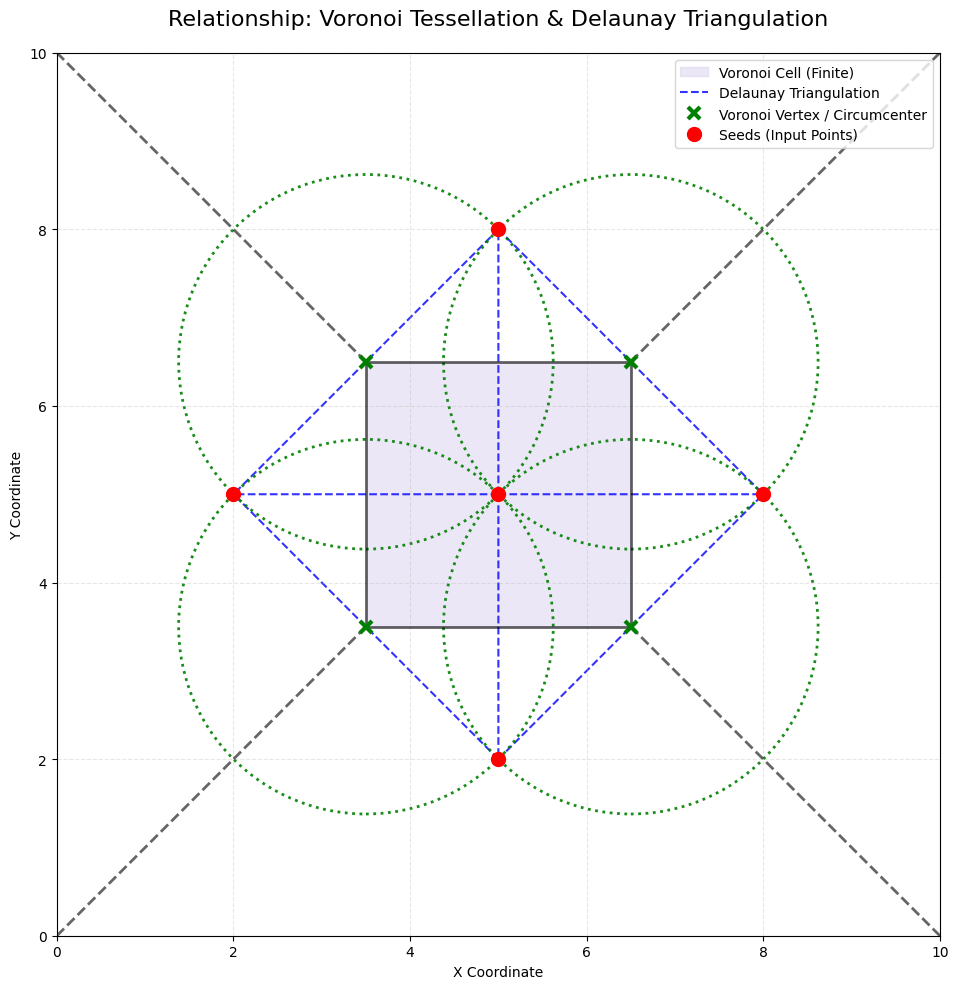

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay

def create_voronoi_delaunay_graph():
    # 1. Setup Seeds
    # We use fixed points in a diamond/cross pattern to ensure we have
    # a nice central "finite" cell to color clearly.
    points = np.array([
        [2.0, 5.0],  # Left
        [8.0, 5.0],  # Right
        [5.0, 8.0],  # Top
        [5.0, 2.0],  # Bottom
        [5.0, 5.0]   # Center
    ])

    # Compute Voronoi and Delaunay
    vor = Voronoi(points)
    tri = Delaunay(points)

    # Setup Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("Relationship: Voronoi Tessellation & Delaunay Triangulation", fontsize=16, pad=20)

    # 2. Plot Voronoi Regions (The Tessellation)
    # voronoi_plot_2d draws the boundaries and vertices
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=2, line_alpha=0.6)

    # Colorize the regions
    # Note: In Scipy, vor.regions contains indices of vertices. -1 indicates a vertex at infinity.
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#D1C4E9']

    for i, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        # Only fill finite regions (those without -1 and having vertices)
        if -1 not in region and len(region) > 0:
            polygon = [vor.vertices[i] for i in region]
            plt.fill(*zip(*polygon), color=colors[i % len(colors)], alpha=0.4, label='Voronoi Cell (Finite)')

    # 3. Plot Delaunay Triangulation
    # These are lines connecting the seeds
    ax.triplot(points[:, 0], points[:, 1], tri.simplices, 'b--', lw=1.5, alpha=0.8, label='Delaunay Triangulation')

    # 4. Plot Circumcircles (The Relationship)
    # The vertices of the Voronoi diagram are the circumcenters of the Delaunay triangles.
    # We iterate over the Voronoi vertices (which are the centers of these circles)
    for v_idx, v_coord in enumerate(vor.vertices):
        # Find the radius: distance from this Voronoi vertex to any of the defining seeds.
        # We simply find the nearest seed to this vertex to get the radius.
        dist = np.min(np.linalg.norm(points - v_coord, axis=1))

        # Draw the circle
        # This circle is centered at the Voronoi Vertex and passes through the Delaunay Triangle points
        circle = plt.Circle(v_coord, dist, color='green', fill=False, linestyle=':', linewidth=2, alpha=0.9)
        ax.add_patch(circle)

        # Mark the center (Voronoi Vertex)
        if 0 < v_coord[0] < 10 and 0 < v_coord[1] < 10:
            ax.plot(v_coord[0], v_coord[1], 'gx', markersize=8, markeredgewidth=3, label='Voronoi Vertex / Circumcenter' if v_idx==0 else "")

    # 5. Plot the Seeds
    ax.plot(points[:, 0], points[:, 1], 'ro', markersize=10, zorder=10, label='Seeds (Input Points)')

    # Styling and Legend
    # Filter duplicate labels for the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

create_voronoi_delaunay_graph()

# **Mathematical Formulation**

#### **1. Voronoi Tessellation**
Given a set of discrete pointing vectors (seeds) $S = \{p_1, p_2, \dots, p_n\}$ in a plane, the Voronoi cell $R_k$ corresponding to a specific pointing vector $p_k$ is defined as the set of all points $x$ closer to $p_k$ than to any other point $p_j$:

$$
R_k = \{x \in \mathbb{R}^2 \mid d(x, p_k) \le d(x, p_j) \quad \forall j \neq k\}
$$

Where $d(x, p)$ is the Euclidean distance:
$$
d(x, p) = \|x - p\|_2 = \sqrt{(x_1 - p_1)^2 + (x_2 - p_2)^2}
$$

#### 2. Delaunay Triangulation & The Empty Circumcircle Property
The Delaunay triangulation is the dual graph of the Voronoi diagram. A triangle formed by three points $\{p_i, p_j, p_k\}$ exists in the Delaunay triangulation if and only if their circumcircle $C$ contains no other points from $S$ in its interior:

$$
\forall p_m \in S \setminus \{p_i, p_j, p_k\}, \quad p_m \notin \text{interior}(C)
$$

The center of this circumcircle, $v_{ijk}$, is a vertex in the Voronoi diagram where the cells $R_i, R_j, R_k$ intersect.

#### 3. Resolution Evaluation (Polygon Area)
To quantify the sampling resolution, we calculate the area of the Voronoi polygon. For a polygon defined by vertices $(x_1, y_1), \dots, (x_n, y_n)$, the area $A$ is calculated using the **Shoelace Formula**:

$$
A = \frac{1}{2} \left| \sum_{i=1}^{n} (x_i y_{i+1} - x_{i+1} y_i) \right|
$$

*(where $(x_{n+1}, y_{n+1}) = (x_1, y_1)$)*

* **Small $A$**: High sampling resolution (Dense).
* **Large $A$**: Low sampling resolution (Sparse).

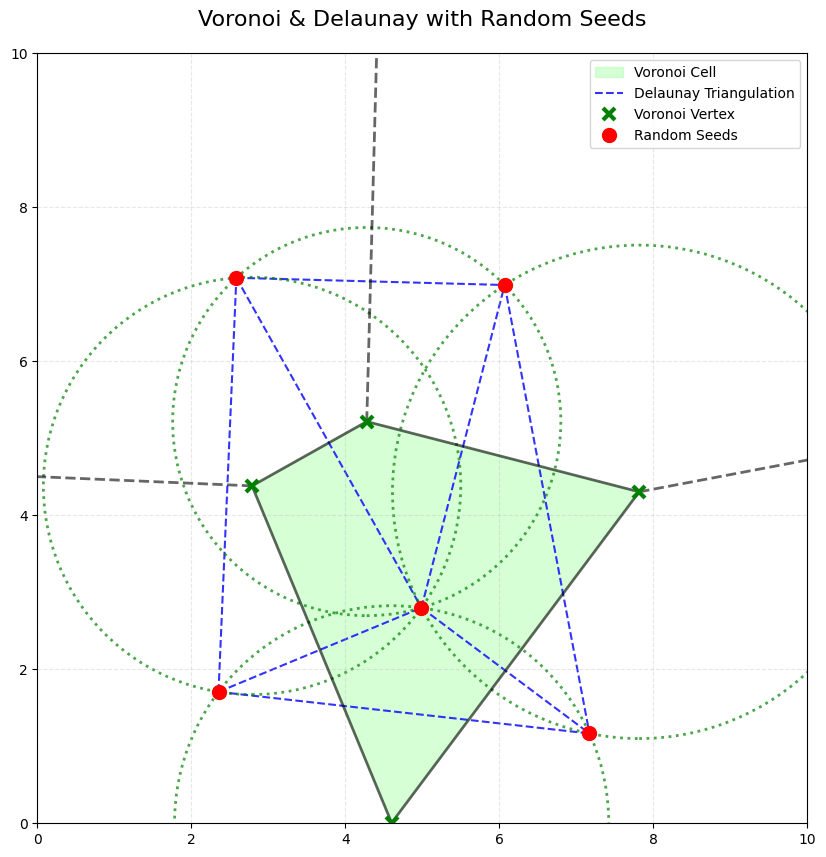

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay

def create_random_voronoi_delaunay():
    # 1. Setup Random Seeds
    np.random.seed(10)  # Change this number to get different random patterns
    num_seeds = 5
    # Generate 5 random points between x=1 and x=9 (to keep them somewhat central)
    points = np.random.uniform(low=1.0, high=9.0, size=(num_seeds, 2))

    # Compute Voronoi and Delaunay
    vor = Voronoi(points)
    tri = Delaunay(points)

    # Setup Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("Voronoi & Delaunay with Random Seeds", fontsize=16, pad=20)

    # 2. Plot Voronoi Regions
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=2, line_alpha=0.6)

    # Colorize regions
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#D1C4E9', '#F0F4C3']
    for i, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 not in region and len(region) > 0:
            polygon = [vor.vertices[i] for i in region]
            plt.fill(*zip(*polygon), color=colors[i % len(colors)], alpha=0.4, label='Voronoi Cell')

    # 3. Plot Delaunay Triangulation
    ax.triplot(points[:, 0], points[:, 1], tri.simplices, 'b--', lw=1.5, alpha=0.8, label='Delaunay Triangulation')

    # 4. Plot Circumcircles
    # Iterate over Voronoi vertices to draw the circumcircles
    for v_idx, v_coord in enumerate(vor.vertices):
        # Calculate radius (distance to nearest seed)
        dist = np.min(np.linalg.norm(points - v_coord, axis=1))

        # Only draw if the circle isn't massive (can happen with near-collinear random points)
        if dist < 15:
            circle = plt.Circle(v_coord, dist, color='green', fill=False, linestyle=':', linewidth=2, alpha=0.7)
            ax.add_patch(circle)

            if 0 < v_coord[0] < 10 and 0 < v_coord[1] < 10:
                ax.plot(v_coord[0], v_coord[1], 'gx', markersize=8, markeredgewidth=3, label='Voronoi Vertex' if v_idx==0 else "")

    # 5. Plot the Seeds
    ax.plot(points[:, 0], points[:, 1], 'ro', markersize=10, zorder=10, label='Random Seeds')

    # Styling
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.show()

create_random_voronoi_delaunay()

# Increasing Number of Seeds and Randomness

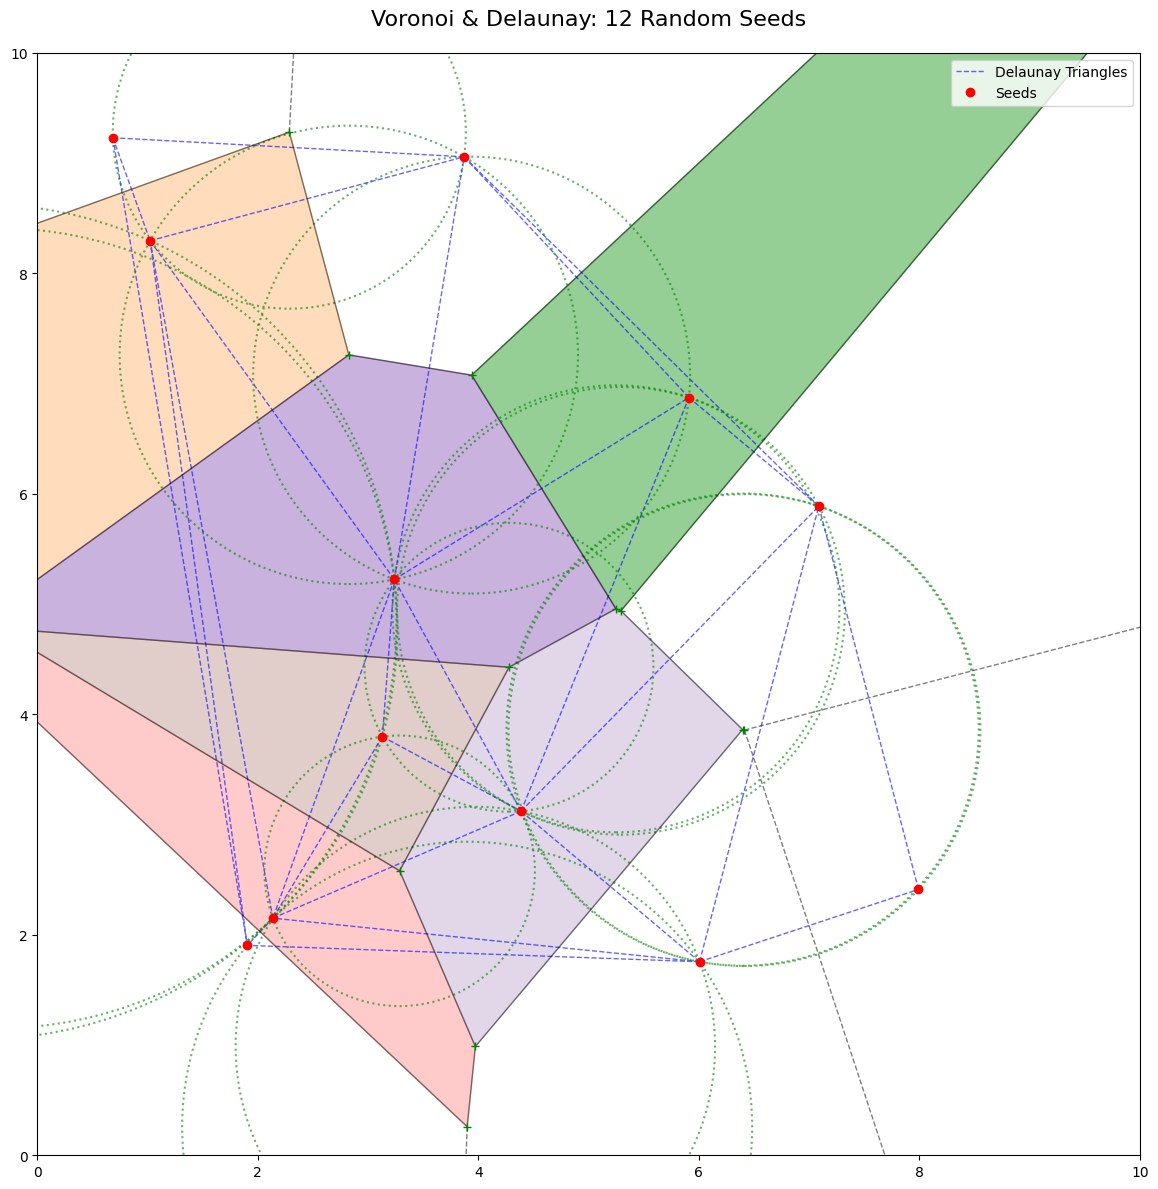

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay

def create_complex_voronoi_delaunay():
    # 1. Setup Random Seeds
    np.random.seed(42)  # Fixed seed for reproducible "randomness"
    num_seeds = 12      # Increased number of seeds

    # Generate random points
    points = np.random.uniform(low=0.5, high=9.5, size=(num_seeds, 2))

    # Compute Voronoi and Delaunay
    vor = Voronoi(points)
    tri = Delaunay(points)

    # Setup Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title(f"Voronoi & Delaunay: {num_seeds} Random Seeds", fontsize=16, pad=20)

    # 2. Plot Voronoi Regions with Various Colors
    # We use a colormap to generate distinct colors for each seed
    cmap = plt.get_cmap('tab20') # 'tab20' has 20 distinct colors

    # Draw boundaries first
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1, line_alpha=0.5)

    # Fill regions
    for i, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 not in region and len(region) > 0:
            polygon = [vor.vertices[i] for i in region]
            # Pick a color based on the index
            c = cmap(i % 20)
            plt.fill(*zip(*polygon), color=c, alpha=0.5)

    # 3. Plot Delaunay Triangulation
    ax.triplot(points[:, 0], points[:, 1], tri.simplices, 'b--', lw=1, alpha=0.6, label='Delaunay Triangles')

    # 4. Plot Circumcircles (The Relationship)
    # With more points, we filter circles to avoid clutter.
    # We only draw circles for triangles that are completely visible within our frame.
    for v_idx, v_coord in enumerate(vor.vertices):
        # Radius is distance to nearest seed
        dist = np.min(np.linalg.norm(points - v_coord, axis=1))

        # Draw circle if it's not too huge (keeps the plot clean)
        if dist < 4:
            circle = plt.Circle(v_coord, dist, color='green', fill=False, linestyle=':', linewidth=1.5, alpha=0.6)
            ax.add_patch(circle)

            # Mark the Voronoi Vertex (Center of the circle)
            if 0 < v_coord[0] < 10 and 0 < v_coord[1] < 10:
                ax.plot(v_coord[0], v_coord[1], 'g+', markersize=6, label='Voronoi Vertices' if v_idx==0 else "")

    # 5. Plot the Seeds
    ax.plot(points[:, 0], points[:, 1], 'r.', markersize=12, zorder=10, label='Seeds')

    # Final settings
    # Deduplicate legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

create_complex_voronoi_delaunay()